<a href="https://colab.research.google.com/github/edatkinson/Prohibited-Item-Detection/blob/main/x_ray_cnn_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

# Check whether we have a GPU.  Use it if we do.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
from google.colab import drive
import pandas as pd
from PIL import Image
import os
from torch.utils.data import Dataset

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the folder
data_dir = '/content/drive/MyDrive/x_ray_dataset'

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# Create dataset class
class X_ray_dataset(Dataset):
    def __init__(self, annotations_file = os.path.join(data_dir, 'binary_classes.csv'), img_dir = os.path.join(data_dir, 'x_ray_images'), transform = None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Test to see if the class is working
x_ray = X_ray_dataset(transform=transform)
print('len dataset:', len(x_ray)) # use the __len__ method to show the length of the dataset
example = x_ray[0] # use the __getitem__ method to get the first example
print(example[0].shape)
print('Class:', example[1])

len dataset: 9841
torch.Size([3, 128, 128])
Class: 1


In [37]:
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

x_ray = X_ray_dataset(transform=transform)
# Define the size of the training set
train_size = int(0.85 * len(x_ray))  # 85% for training

# Split the dataset into training and testing sets
train_ds, test_ds = random_split(x_ray, [train_size, len(x_ray) - train_size])

# Split the training set into train and validation (train ~ 70% (6887), test ~ 15% (1477), val ~ 15% (1477))
train_ds, val_ds = random_split(train_ds, [6887, 1477])

# Define class labels
classes = ('Safe', 'Prohibited')

# Define batch size
batch_size = 10

# Calculate the number of classes in train and val sets
class_0_count_train = 0
class_1_count_train = 0
class_0_count_val = 0
class_1_count_val = 0

for image, label in train_ds:  # count classes for train
    if label == 0:
        class_0_count_train += 1
    elif label == 1:
        class_1_count_train += 1

for image, label in val_ds:  # count classes for validation
    if label == 0:
        class_0_count_val += 1
    elif label == 1:
        class_1_count_val += 1

# Extract the class labels from the dataset
train_targets = torch.tensor([label for _, label in train_ds])
val_targets = torch.tensor([label for _, label in val_ds])

# Calculate weights for each class
class_sample_count = torch.tensor([class_0_count_train, class_1_count_train])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in train_targets])

# WeightedRandomSampler for training set
train_sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

# For validation, you can repeat the process if you want stratified sampling there as well
val_class_sample_count = torch.tensor([class_0_count_val, class_1_count_val])
val_weight = 1. / val_class_sample_count.float()
val_samples_weight = torch.tensor([val_weight[t] for t in val_targets])

val_sampler = WeightedRandomSampler(weights=val_samples_weight, num_samples=len(val_samples_weight), replacement=True)

# Data loaders with stratified sampling
train_loader = DataLoader(train_ds,
                          batch_size=10,
                          sampler=train_sampler,
                          shuffle = False)  # don't shuffle with stratified sampling
test_loader = DataLoader(test_ds,
                         batch_size = batch_size*5,
                         shuffle = False)
val_loader = DataLoader(val_ds,
                        batch_size=10*5,
                        sampler=val_sampler,
                        shuffle = False)

In [38]:
import torch.nn as nn

# Create CNN
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # Creating layers
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3)
    self.batch1 = nn.BatchNorm2d(128)
    self.relu1 = nn.ReLU()
    #self.pool1 = nn.MaxPool2d(2,2)

    self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 10, kernel_size = 3)
    self.batch2 = nn.BatchNorm2d(10)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.AdaptiveAvgPool2d(1)

    #self.conv3 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3)
    #self.pool3 = nn.MaxPool2d(2,2)

    #self.conv4 = nn.Conv2d(in_channels = 1024, out_channels = 2048, kernel_size = 3)
    #self.pool4 = nn.MaxPool2d(2,2)

    #self.conv5 = nn.Conv2d(in_channels = 2048, out_channels = 4096, kernel_size = 3)
    #self.pool5 = nn.MaxPool2d(2,2)

    #self.conv6 = nn.Conv2d(in_channels = 4096, out_channels = 8192, kernel_size = 3)
    #self.pool6 = nn.MaxPool2d(2,2)

    # flatten (make it a vector) so can make normal linear layers like a fully connected NN
    #self.flatten = nn.Flatten()

    #self.fc1 = nn.Linear(in_features = 1968128, out_features = 2048)
    #self.drop1 = nn.Dropout(p = 0.3)

    #self.fc2 = nn.Linear(in_features = 2048, out_features = 1024)
    #self.drop2 = nn.Dropout(p = 0.3)

    # Output Layer ending in 2 values (rough probability distribution over the 2 classes)
    #self.out = nn.Linear(in_features = 512, out_features = 2)


  def forward(self, x):
    x = nn.functional.relu(self.conv1(x)) # apply non-linearity
    x = self.batch1(x)
    x = self.relu1(x)
    #x = self.pool1(x)

    x = nn.functional.relu(self.conv2(x)) # apply non-linearity
    x = self.batch2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    #x = nn.functional.relu(self.conv3(x)) # apply non-linearity
    #x = self.pool3(x)

    #x = nn.functional.relu(self.conv4(x)) # apply non-linearity
    #x = self.pool4(x)

    #x = nn.functional.relu(self.conv5(x)) # apply non-linearity
    #x = self.pool5(x)

    #x = nn.functional.relu(self.conv6(x)) # apply non-linearity
    #x = self.pool6(x)

    #x = self.flatten(x)

    #x = nn.functional.relu(self.fc1(x))
    #x = self.drop1(x) # dropout to prevent overfitting

    #x = nn.functional.relu(self.fc2(x))
    #x = self.drop2(x) # dropout to prevent overfitting

    #x = self.out(x)

    return x

In [39]:
# Instantiate Network
net = CNN()
net.to(device)

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(128, 10, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): AdaptiveAvgPool2d(output_size=1)
)

In [40]:
# Checking the shape of an image before and after the network
for i, data in enumerate(train_loader):
  inputs, labels = data[0].to(device), data[1].to(device)
  print('Input shape:', inputs.shape)
  print('Output shape:', net(inputs).shape)
  break

Input shape: torch.Size([10, 3, 128, 128])
Output shape: torch.Size([10, 10, 1, 1])


In [41]:
# Specifying hyperparameters
import torch.optim as optim

class CustomCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()

    def forward(self, input, target):
        log_softmax_values = torch.log_softmax(input, dim=1)

        # Calculate class weights
        class_weights = torch.tensor([1.0 / count for count in torch.bincount(target)], device=input.device)

        # Weight the losses by class weights
        weighted_losses = -target * log_softmax_values * class_weights[target]

        return torch.mean(torch.sum(weighted_losses, dim=1))


loss_func = nn.CrossEntropyLoss()
#loss_func = CustomCrossEntropyLoss

optimiser = optim.Adam(net.parameters(), lr = 0.001)

In [42]:
# Function for training one epoch
def train_epoch():
  net.train(True) # set to training mode

  # Metrics that will build up
  running_loss = 0
  running_accuracy = 0

  # Iterate over train data
  for batch_index, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device) # get the images and labels

    optimiser.zero_grad() # set all non-zero values for gradients to 0 (reset gradients)

    outputs = net(inputs).squeeze((-1, -2)) # shape: [batch size, 2]
    correct_prediction = torch.sum(labels == torch.argmax(outputs, dim = 1)).item() # check how many images the model predicted correctly
    running_accuracy += correct_prediction/batch_size # update the accuracy

    # Train model
    loss = loss_func(outputs, labels) # compare model predictions with labels
    running_loss += loss.item() # update the loss
    loss.backward() # calculate gradients
    optimiser.step()

    if batch_index % 50 == 49:      # print for every 500 batchs
      avg_loss = running_loss/50  # get the average loss across batches
      avg_acc = (running_accuracy/50) * 100 # get the average accuracy across batches
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss, avg_acc))

      running_loss = 0
      running_accuracy = 0

  print()


In [43]:
# Function for validating one epoch
def validate_epoch():
  net.train(False) # set to evaluation mode
  running_loss = 0
  running_acc = 0

  # Iterate over validation data
  for batch_index, data in enumerate(val_loader):
    inputs, labels = data[0].to(device), data[1].to(device)

    with torch.no_grad(): # not worried about gradients here as not training
      outputs = net(inputs).squeeze((-1, -2)) # shape [batch size, 2]
      correct_prediction = torch.sum(labels == torch.argmax(outputs, dim = 1)).item() # check how many images the model predicted correctly
      running_acc += correct_prediction/(batch_size*5) # update the accuracy
      loss = loss_func(outputs, labels) # compare model predictions with labels
      running_loss += loss.item() # update the loss

  avg_loss = running_loss/len(val_loader)
  avg_acc = (running_acc/len(val_loader)) * 100

  print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss, avg_acc))

  print('-----------------------------------------------------------')
  print()



In [44]:
# Function for testing
def test_epoch(epoch):
  with torch.no_grad():
    correct_prediction = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = net(images).squeeze((-1,-2))

      predicted = torch.argmax(outputs, -1)
      correct_prediction += (predicted == labels).sum().item()
      total += labels.size(0)

    acc =(correct_prediction/total) * 100

    print('Test accuracy after {0:.0f} epoch(s): {1:.1f}%'.format(epoch+1, acc))
    print()

In [45]:
# Training loop

num_epochs = 1

for i in range(num_epochs):
  print('Epoch:', i+1, '\n')

  train_epoch()
  test_epoch(i)
  validate_epoch()

print('Finished Training')

Epoch: 1 

Batch 50, Loss: 1.821, Accuracy: 81.4%
Batch 100, Loss: 1.627, Accuracy: 93.4%
Batch 150, Loss: 1.559, Accuracy: 91.6%
Batch 200, Loss: 1.464, Accuracy: 96.2%
Batch 250, Loss: 1.451, Accuracy: 94.4%
Batch 300, Loss: 1.345, Accuracy: 95.8%
Batch 350, Loss: 1.298, Accuracy: 97.2%
Batch 400, Loss: 1.265, Accuracy: 95.8%
Batch 450, Loss: 1.196, Accuracy: 96.8%
Batch 500, Loss: 1.157, Accuracy: 95.2%
Batch 550, Loss: 1.095, Accuracy: 95.4%
Batch 600, Loss: 1.024, Accuracy: 96.8%
Batch 650, Loss: 1.008, Accuracy: 96.0%

Test accuracy after 1 epoch(s): 97.5%

Val Loss: 0.893, Val Accuracy: 94.5%
-----------------------------------------------------------

Finished Training


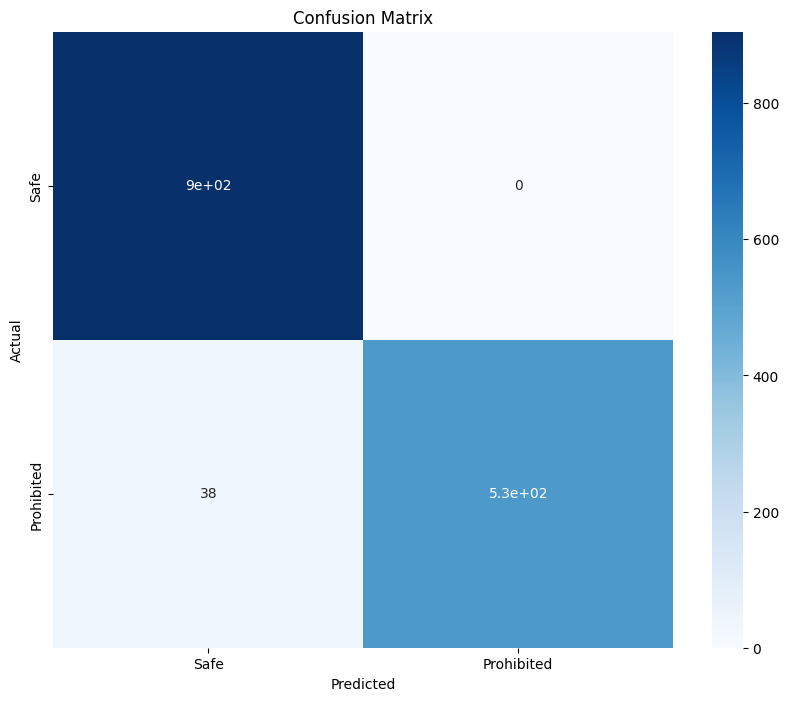

In [46]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

net.eval()
y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    y_true += labels.tolist()
    y_pred += predicted.tolist()

y_pred_flattened = [item for sublist in y_pred for subsublist in sublist for item in subsublist]

cm = confusion_matrix(y_true, y_pred_flattened)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(y_true)
print(y_pred_flattened)

[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 